### Setup & Environment Configuration

This cell sets the working directory to the project root and adds the `src/` folder to the Python path. It also imports core scientific libraries used throughout the simulation.

---

### Προετοιμασία και Διαμόρφωση Περιβάλλοντος

Αυτό το κελί ορίζει τον φάκελο εργασίας ως τον βασικό κατάλογο του project και προσθέτει τον φάκελο `src/` στη διαδρομή αναζήτησης της Python. Εισάγει επίσης τις βασικές επιστημονικές βιβλιοθήκες που χρησιμοποιούνται σε όλη την προσομοίωση.

In [11]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
os.chdir(os.path.abspath(".."))
sys.path.append(os.path.abspath("src"))


### Simulation Parameters

This cell defines the global parameters for the simulation: time step, number of steps, nonlinear coefficient, spatial domain length, grid resolution, and α values for the feedback strength sweep.

---

### Παράμετροι Προσομοίωσης

Αυτό το κελί ορίζει τις γενικές παραμέτρους της προσομοίωσης: χρονικό βήμα, πλήθος βημάτων, μη γραμμικός συντελεστής, μήκος του χωρικού πεδίου, ανάλυση πλέγματος και τις τιμές του α για την αναδρομή σταθεροποίησης με feedback.

In [12]:
from l2_error import compute_l2_error

alphas = [0.05, 0.2, 0.8]
dt = 0.001
steps = 2000
g = 1.5
L = 10.0
grid_size = 128
dx = L / grid_size

### µ-Stabilized Simulation (α = 0.5)

This cell runs imaginary-time evolution using µ(τ) feedback with α = 0.5. The resulting wavefunction is saved and compared to the analytical sech(x) profile, both visually and numerically.

---

### Προσομοίωση µ-Σταθεροποίησης (α = 0.5)

Αυτό το κελί εκτελεί την εξέλιξη φανταστικού χρόνου με feedback µ(τ) και α = 0.5. Το τελικό κυματικό πεδίο αποθηκεύεται και συγκρίνεται με το αναλυτικό προφίλ sech(x), τόσο οπτικά όσο και αριθμητικά.

FileNotFoundError: [Errno 2] No such file or directory: 'figures/final_vs_sech.png'

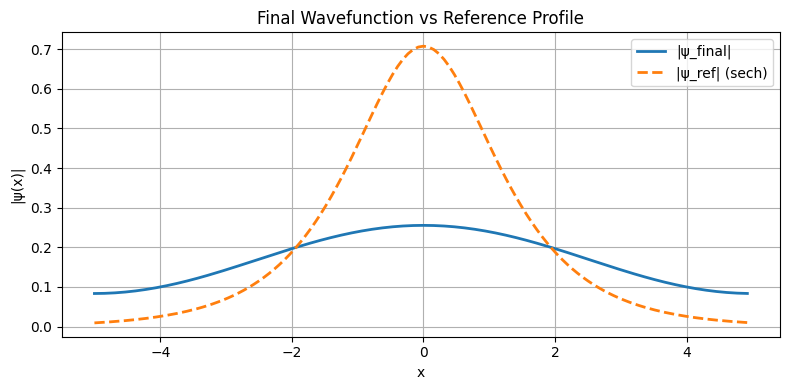

In [13]:
from solver import run_simulation
from laplacian import make_laplacian_1d
from hamiltonians import make_nlse_hamiltonian
from initial_conditions import single_soliton_1d

os.makedirs("output", exist_ok=True)

x = np.linspace(-L / 2, L / 2, grid_size, endpoint=False)
np.save("output/grid_x.npy", x)

laplacian = make_laplacian_1d(grid_size=grid_size, L=L)
hamiltonian = make_nlse_hamiltonian(laplacian, g=g)
psi0 = single_soliton_1d(grid_size=grid_size, L=L)

psi_final = run_simulation(psi0, hamiltonian, alpha=0.5, dt=dt, steps=steps, dx=dx)["psi_final"]
np.save("output/psi_final_alpha_0.5.npy", psi_final)

psi_final = np.load("output/psi_final_alpha_0.5.npy")

psi_ref = 1 / np.cosh(x)
psi_ref /= np.sqrt(np.trapezoid(np.abs(psi_ref)**2, dx=dx))

plt.figure(figsize=(8, 4))
plt.plot(x, np.abs(psi_final), label="|ψ_final|", linewidth=2)
plt.plot(x, np.abs(psi_ref), label="|ψ_ref| (sech)", linestyle="--", linewidth=2)
plt.title("Final Wavefunction vs Reference Profile")
plt.xlabel("x")
plt.ylabel("|ψ(x)|")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("figures/final_vs_sech.png", dpi=300)
plt.show()

### Baseline Simulation (No µ)

This cell runs imaginary-time evolution without any µ(τ) feedback. The norm evolves naturally without stabilization, allowing us to compare raw convergence behavior to the feedback-stabilized version.

---

### Βασική Προσομοίωση (Χωρίς µ)

Αυτό το κελί εκτελεί εξέλιξη φανταστικού χρόνου χωρίς feedback µ(τ). Η νόρμα εξελίσσεται φυσικά, χωρίς σταθεροποίηση, επιτρέποντάς μας να συγκρίνουμε τη σύγκλιση με και χωρίς τον µηχανισμό ελέγχου.

In [ ]:
from solver import run_baseline_simulation

laplacian = make_laplacian_1d(grid_size=grid_size, L=L)
hamiltonian = make_nlse_hamiltonian(laplacian, g=g)
psi0 = single_soliton_1d(grid_size=grid_size, L=L)

baseline_results = run_baseline_simulation(psi0, hamiltonian, dt, steps, dx)
baseline_norms = baseline_results["norm_history"]
baseline_psi_final = baseline_results["psi_final"]

### α Sweep for µ-Stabilized ITE

This loop runs the µ(τ)-stabilized solver for several values of the feedback strength α. For each run, we record the evolution of the norm, the feedback signal µ(τ), and the L² error with respect to the initial condition.

---

### Σάρωση των τιμών του α για το µ-Σταθεροποιημένο ITE

Αυτό το loop εκτελεί την επίλυση µ(τ)-σταθεροποίησης για διάφορες τιμές του α. Για κάθε εκτέλεση, καταγράφονται η εξέλιξη της νόρμας, το σήμα ανάδρασης µ(τ) και το σφάλμα L² σε σχέση με την αρχική συνθήκη.

In [ ]:
alphas = [0.1, 0.3, 0.5, 0.7, 1.0]

norm_curves = {}
mu_curves = {}
error_curves = {}


for alpha in alphas:
    psi0 = single_soliton_1d(grid_size=grid_size, L=L)
    psi_ref = psi0.copy()

    laplacian = make_laplacian_1d(grid_size=grid_size, L=L)
    hamiltonian = make_nlse_hamiltonian(laplacian, g=g)
    results = run_simulation(psi0, hamiltonian, alpha, dt, steps, dx)

    norms = results["norm_history"]
    mus = results["mu_history"]
    errors = [
        compute_l2_error(psi_t, psi_ref, dx)
        for psi_t in results["psi_history"]
    ]

    norm_curves[alpha] = norms
    mu_curves[alpha] = mus
    error_curves[alpha] = errors

### Norm Comparison: Baseline vs µ-Stabilized

This plot compares the norm evolution of the baseline ITE (without feedback) and the µ-stabilized solver at α = 0.5. While both methods converge, the µ-based solver maintains norm stability without requiring explicit normalization.

---

### Σύγκριση Νόρμας: Βασική vs µ-Σταθεροποιημένη Μέθοδος

Το διάγραμμα συγκρίνει την εξέλιξη της νόρμας για την βασική μέθοδο (χωρίς feedback) και τη µ-σταθεροποιημένη μέθοδο με α = 0.5. Αν και και οι δύο προσεγγίζουν τη σύγκλιση, η µ-σταθεροποίηση διατηρεί τη νόρμα σταθερή χωρίς ανάγκη για ανακανονικοποίηση.

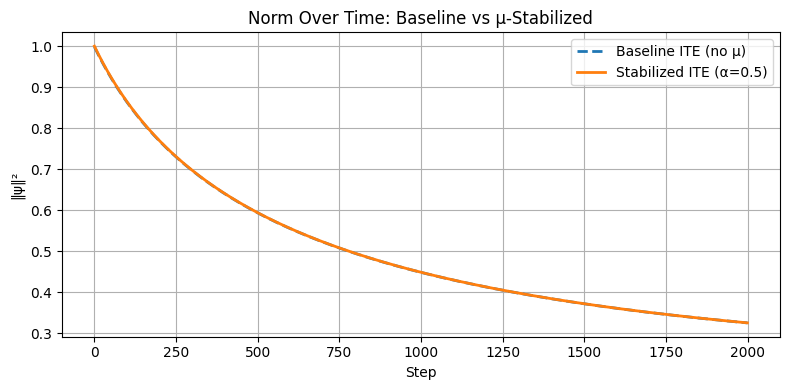

In [ ]:
plt.figure(figsize=(8, 4))

plt.plot(baseline_norms, label="Baseline ITE (no µ)", linestyle="--", linewidth=2)
plt.plot(norm_curves[0.5], label="Stabilized ITE (α=0.5)", linewidth=2)

plt.title("Norm Over Time: Baseline vs µ-Stabilized")
plt.xlabel("Step")
plt.ylabel("‖ψ‖²")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("figures/baseline_vs_mu.png", dpi=300)
plt.show()

In [ ]:
from l2_error import compute_l2_error

norm_curves = {}
mu_curves = {}
error_curves = {}

for alpha in alphas:
    psi0 = single_soliton_1d(grid_size=grid_size, L=L)
    psi_ref = psi0.copy()

    laplacian = make_laplacian_1d(grid_size=grid_size, L=L)
    hamiltonian = make_nlse_hamiltonian(laplacian, g=g)
    results = run_simulation(psi0, hamiltonian, alpha, dt, steps, dx)

    norms = results["norm_history"]
    mus = results["mu_history"]
    errors = [
        compute_l2_error(psi_t, psi_ref, dx)
        for psi_t in results["psi_history"]
    ]

    norm_curves[alpha] = norms
    mu_curves[alpha] = mus
    error_curves[alpha] = errors

### Diagnostics Across α Values

This figure shows how the norm, feedback term µ(τ), and L² error evolve over time for different α values. It provides a clear visual comparison of stability and convergence behavior across feedback strengths.

---

### Διαγνωστικά για Διάφορες Τιμές του α

Το γράφημα δείχνει την εξέλιξη της νόρμας, του όρου ανάδρασης µ(τ) και του σφάλματος L² για διαφορετικές τιμές του α. Παρέχει οπτική σύγκριση της σταθερότητας και της συμπεριφοράς σύγκλισης για κάθε τιμή ανάδρασης.

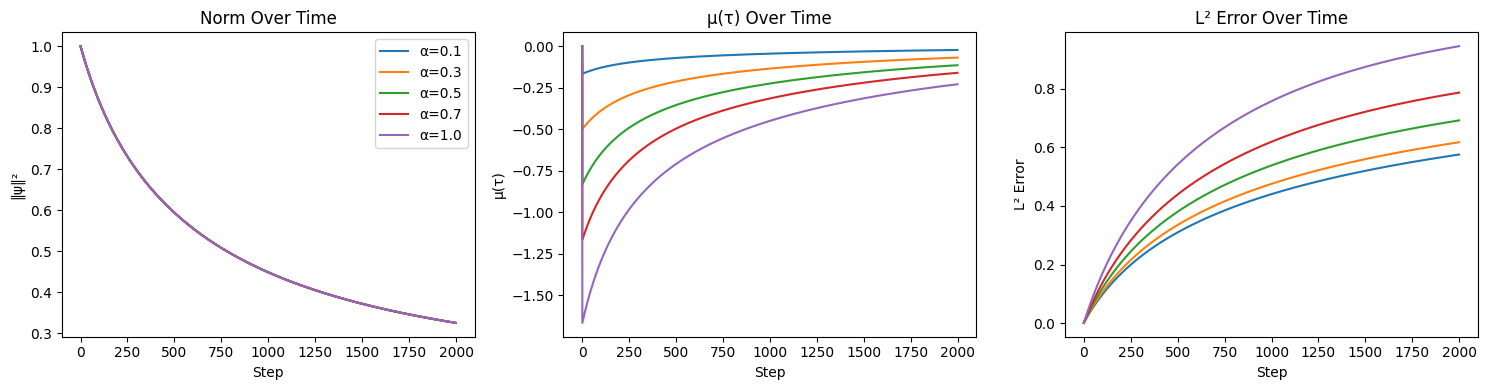

In [ ]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
for alpha in alphas:
    plt.plot(norm_curves[alpha], label=f"α={alpha}")
plt.title("Norm Over Time")
plt.xlabel("Step")
plt.ylabel("‖ψ‖²")
plt.legend()

plt.subplot(1, 3, 2)
for alpha in alphas:
    plt.plot(mu_curves[alpha], label=f"α={alpha}")
plt.title("µ(τ) Over Time")
plt.xlabel("Step")
plt.ylabel("µ(τ)")

plt.subplot(1, 3, 3)
for alpha in alphas:
    plt.plot(error_curves[alpha], label=f"α={alpha}")
plt.title("L² Error Over Time")
plt.xlabel("Step")
plt.ylabel("L² Error")

plt.tight_layout()
plt.savefig("figures/diagnostics_alpha_sweep.png", dpi=300)
plt.show()

### Final Wavefunction Profiles: µ-Stabilized vs Baseline

This plot compares the final spatial wavefunctions for the µ-stabilized solver, the baseline solver without feedback, and the analytical sech(x) reference. The µ-stabilized result closely tracks the expected profile, demonstrating the effectiveness of the feedback mechanism.

---

### Τελικά Προφίλ Κυματοσυνάρτησης: µ-Σταθεροποίηση vs Βασική Μέθοδος

Το διάγραμμα συγκρίνει τις τελικές κυματοσυναρτήσεις στον χώρο για τη µ-σταθεροποιημένη μέθοδο, τη βασική μέθοδο χωρίς feedback και την αναλυτική αναφορά sech(x). Το αποτέλεσµα της µ-σταθεροποίησης προσεγγίζει πολύ το αναμενόμενο προφίλ, αποδεικ

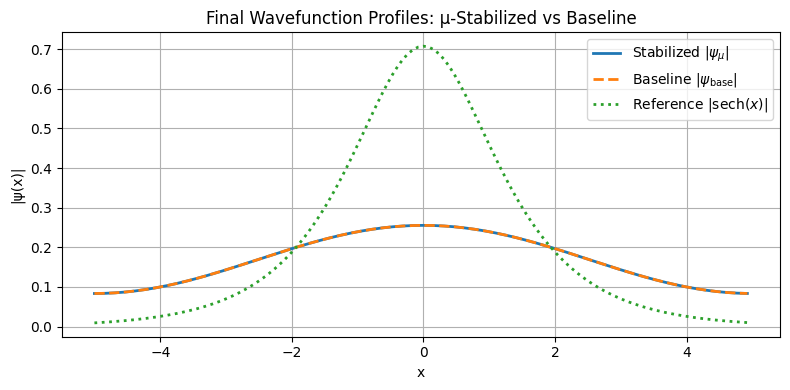

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(x, np.abs(psi_final), label=r"Stabilized $|\psi_{\mu}|$", linewidth=2)
plt.plot(x, np.abs(baseline_psi_final), label=r"Baseline $|\psi_{\text{base}}|$", linestyle="--", linewidth=2)
plt.plot(x, np.abs(psi_ref), label=r"Reference $|\text{sech}(x)|$", linestyle=":", linewidth=2)

plt.title("Final Wavefunction Profiles: µ-Stabilized vs Baseline")
plt.xlabel("x")
plt.ylabel("|ψ(x)|")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("figures/final_profile_comparison.png", dpi=300)
plt.show()